In [26]:
import pandas
import sqlalchemy
import matplotlib.pyplot as plt

In [280]:
engine = sqlalchemy.create_engine('sqlite:///solarthermal.db')

In [355]:
sql = "SELECT * FROM solarthermal WHERE timestamp > '2024-01-22 08:00'"
df = pandas.read_sql(sql, engine)
df['timestamp'] = pandas.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df = df.rename(columns={'temp1': 't_ret', 'temp2': 't_flow', 'temp3': 't_ambient'})
df['temp_diff'] = df['t_ret'] - df['t_flow']

Text(0, 0.5, 'Temp in degC')

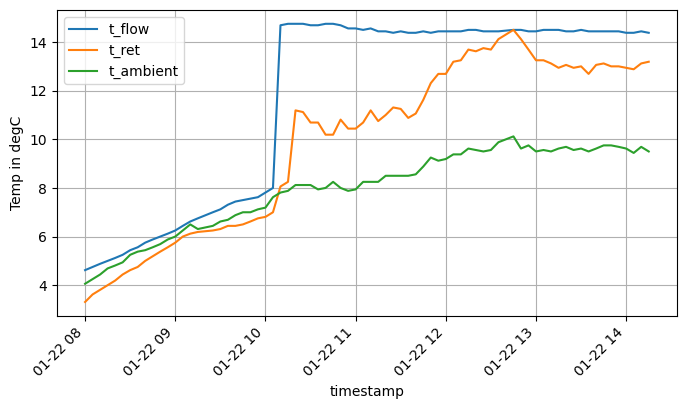

In [356]:
fig, ax = plt.subplots(figsize=(8, 4.5))

df.plot(ax=ax, y=['t_flow', 't_ret', 't_ambient'], rot=45, grid=True)
ax.set_ylabel('Temp in degC')

Text(0, 0.5, 'Delta T in degC')

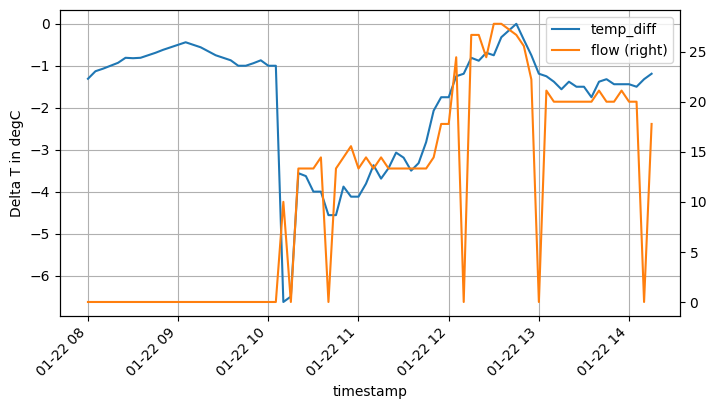

In [357]:
fig, ax = plt.subplots(figsize=(8, 4.5))

df.plot(ax=ax, y='temp_diff', rot=45, grid=True)
df.plot(ax=ax, y='flow', secondary_y=True, rot=45)
ax.set_ylabel('Delta T in degC')

<Axes: xlabel='timestamp'>

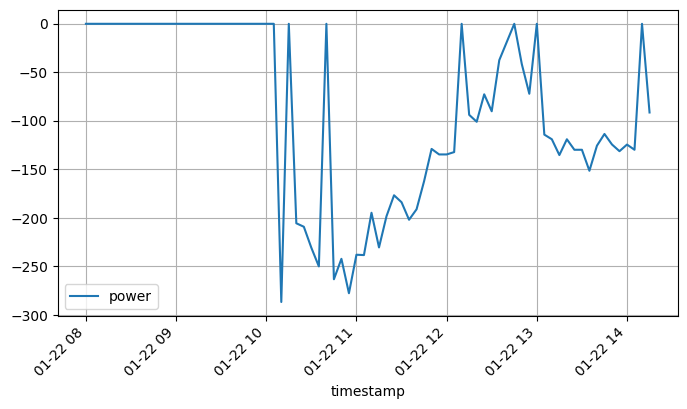

In [358]:
fig, ax = plt.subplots(figsize=(8, 4.5))

df.plot(ax=ax, y='power',rot=45, grid=True)

# How much energy

In [359]:
energy = df.resample('15T').mean()['power'].sum() / 4
energy

-583.6512499999999

# How many kWh to raise one degree?
222 gal = 0.840361 cubic meter

In [360]:
m = 840 # kg
cp = 4.186 # kJ/kg/K
delta_T = 1
E_J = m * cp * delta_T
E_kWh = E_J/3600
E_kWh

0.9767333333333332

# How much should the temperature have risen?

In [343]:
delta_t_theoretical = energy / 1000/ E_kWh
delta_t_theoretical

-0.430683912360931

In [344]:
# First and last  flow temperature where we had flow of more than 20 g/s
moving = df[df['flow']>15]['t_flow']
moving.iloc[-1] - moving.iloc[0]

-0.120000000000001

In [345]:
moving

timestamp
2024-01-22 10:55:03.431552    14.56
2024-01-22 11:55:03.125139    14.44
2024-01-22 12:00:04.015477    14.44
2024-01-22 12:05:03.698180    14.44
2024-01-22 12:15:03.478233    14.50
2024-01-22 12:20:03.614880    14.50
2024-01-22 12:25:03.420667    14.44
2024-01-22 12:30:03.387985    14.44
Name: t_flow, dtype: float64

# Daily analysis

In [346]:
df_all = pandas.read_sql('solarthermal', engine)
df_all = df_all.rename(columns={'temp1': 't_ret', 'temp2': 't_flow', 'temp3': 't_ambient'})
df_all['timestamp'] = pandas.to_datetime(df_all['timestamp'])
df_all.set_index('timestamp', inplace=True)

## Max flow temperature every day

In [347]:
df_all[df_all['flow']>10]['t_flow'].resample('D').max()

timestamp
2024-01-06    14.56
2024-01-07    12.38
2024-01-08    11.19
2024-01-09    11.12
2024-01-10    11.38
2024-01-11    11.25
2024-01-12     9.69
2024-01-13    10.19
2024-01-14    13.81
2024-01-15    14.62
2024-01-16    14.94
2024-01-17    15.06
2024-01-18    13.94
2024-01-19    14.25
2024-01-20    15.25
2024-01-21    16.19
2024-01-22    14.75
Freq: D, Name: t_flow, dtype: float64

<Axes: xlabel='timestamp'>

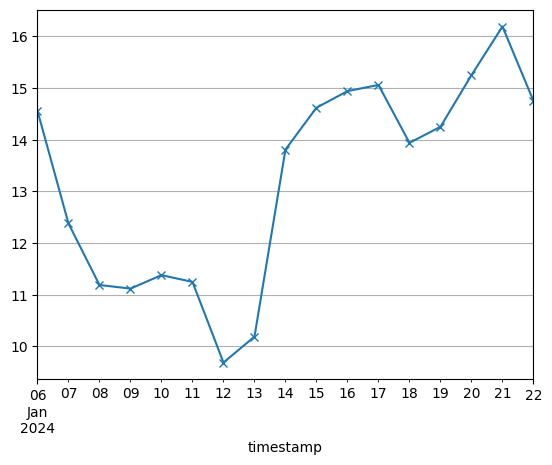

In [348]:
df_all[df_all['flow']>10]['t_flow'].resample('D').max().plot(grid=True, marker='x')

## Daily lift 

In [349]:
daily_max = df_all[df_all['flow']>10]['t_flow'].resample('D').max()
daily_min = df_all[df_all['flow']>10]['t_flow'].resample('D').min()
daily_max - daily_min

timestamp
2024-01-06    0.00
2024-01-07    0.94
2024-01-08    1.31
2024-01-09    0.81
2024-01-10    0.69
2024-01-11    1.69
2024-01-12    0.31
2024-01-13    1.25
2024-01-14    3.25
2024-01-15    2.37
2024-01-16    1.82
2024-01-17    2.12
2024-01-18    0.75
2024-01-19    1.06
2024-01-20    2.13
2024-01-21    2.44
2024-01-22    0.37
Freq: D, Name: t_flow, dtype: float64

## Nightly drop

In [350]:
daily_max_shift = daily_max.copy()
daily_max_shift.index = daily_max_shift.index.shift(1, freq='D')
daily_min - daily_max_shift

timestamp
2024-01-06     NaN
2024-01-07   -3.12
2024-01-08   -2.50
2024-01-09   -0.88
2024-01-10   -0.43
2024-01-11   -1.82
2024-01-12   -1.87
2024-01-13   -0.75
2024-01-14    0.37
2024-01-15   -1.56
2024-01-16   -1.50
2024-01-17   -2.00
2024-01-18   -1.87
2024-01-19   -0.75
2024-01-20   -1.13
2024-01-21   -1.50
2024-01-22   -1.81
2024-01-23     NaN
Freq: D, Name: t_flow, dtype: float64

## Energy every day

<Axes: xlabel='timestamp'>

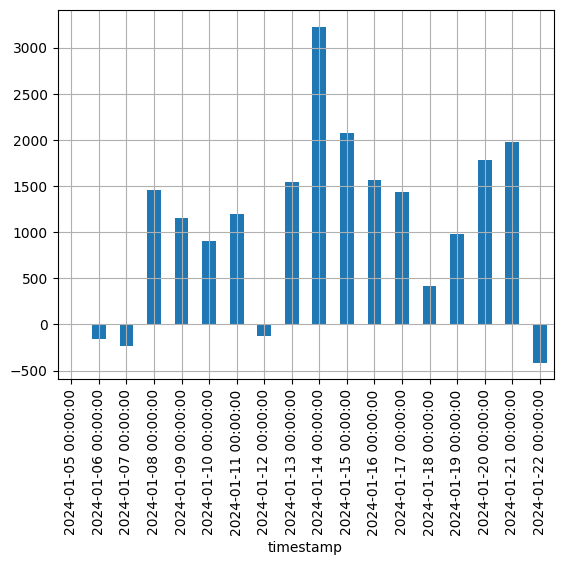

In [351]:
(df_all['power'].resample('15T').mean()/4).resample('D').sum().plot.bar(grid=True)

## When do we get power?

<Axes: xlabel='hour_of_day'>

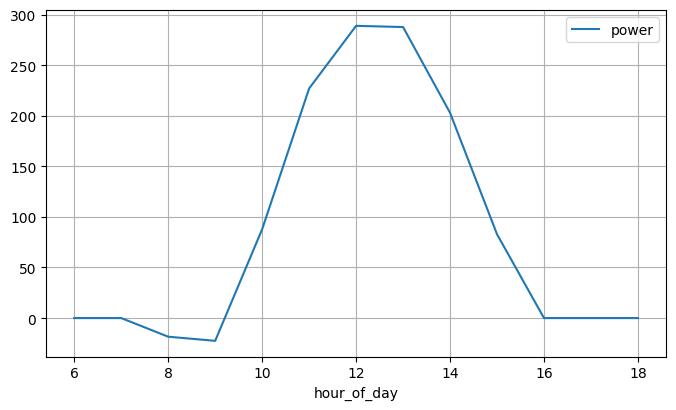

In [352]:
fig, ax = plt.subplots(figsize=(8, 4.5))

df_all['hour_of_day'] = df_all.index.hour
df_all.groupby('hour_of_day').mean().plot(y='power', ax=ax, grid=True)

<Axes: xlabel='minute_of_day'>

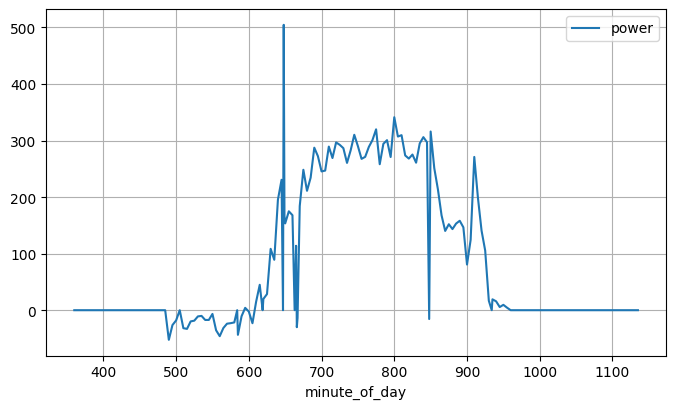

In [353]:
fig, ax = plt.subplots(figsize=(8, 4.5)) 

#df_all['15_min_chunk'] = (df_all.index.hour * 60 + df_all.index.minute) // 15
#df_all.groupby('15_min_chunk').mean().plot(y='power', ax=ax, grid=True)

df_all['minute_of_day'] = df_all.index.hour * 60 + df_all.index.minute
df_all.groupby('minute_of_day').mean().plot(y='power', ax=ax, grid=True)

# Does Power depend on ambient temperature?

<Axes: xlabel='t_ambient', ylabel='power'>

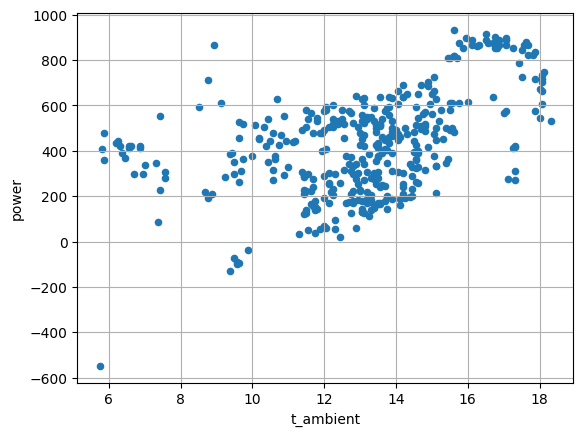

In [354]:
df_all[df_all['flow']>20].plot.scatter(x='t_ambient', y='power', grid=True)